# Technical Analysis for Stock Price Prediction #
Team Members: Anjan Shrestha, Krishna Sathvik Mantripragada, Sai Tarun Gunda, Tharun Digajari

Group Number: 14

### Import and Packages ###

In [1]:
# For dealing with dataframe
import pandas as pd

# For dealing with np array
import numpy as np

# For calling yahoo finance to get stock price 
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta

# For plotting
import matplotlib.pyplot as plt

# For model
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# For upgrading pandas datareader module
!pip install --upgrade pandas_datareader

### Model Properties ###

In [2]:
# Dataset Properties
DATE = 'Date'
CLOSE = 'Close'
VOLUME = 'Volume'

# Stock Properties 
STOCK_TICKER = 'AAPL' # Stock ticker name to run the model

# Target
NUMBER_OF_DAYS_TO_PREDICT = 30 # Target Stock Trend

# Custom Hyperparameters
NUMBER_OF_YEARS_TO_FETCH_PRICE_DATA = [5, 15]
NUMBER_OF_DAYS_FOR_PRICE_PREDICTION = [20, 50]

# LSTM Hyperparameters
NUMBER_OF_EPOCH_LIST = [25, 50]
BATCH_SIZE_LIST = [30, 60]

# KNN Hyperparameters
KNN_NEIGHBORS_LIST = [1, 3, 5, 7, 9]

# Decision Tree Hyperparameters
MIN_SAMPLES_LIST = [2, 3, 5, 7, 9]

##  1. Extract Raw data and Dataset Creation ##
Calling Yahoo Finance API to extract data for last 'n' years from current date and convert it to dataframe

In [3]:
# Function to Create Dataset
def extract_raw_data(number_of_years_to_fetch_price_data):
    # Getting start and end date for stock data
    end_date = dt.date.today()
    start_date = end_date - timedelta(days=number_of_years_to_fetch_price_data * 365)  # Getting start date as last 'n' number of years from now

    # Calling Yahoo Finance API for last 7 years of stock data 
    df = pdr.get_data_yahoo(STOCK_TICKER, start = start_date, end = end_date)
    
    return df

## 2. Exploratory Data Analysis

<AxesSubplot:title={'center':'Stock Price Movement for last 15 years'}, xlabel='Date', ylabel='Stock Price'>

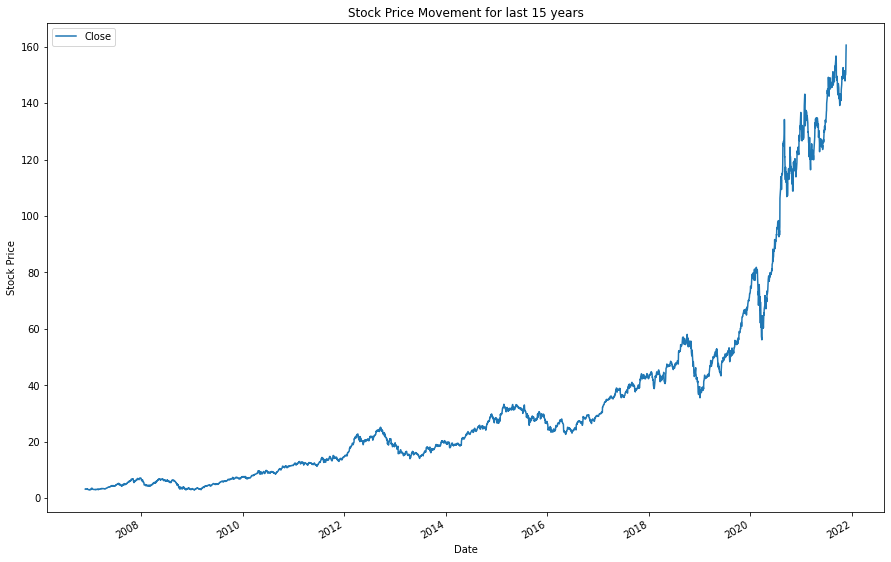

In [4]:
# Plotting the graph visualizing price change with date with 15 years of data
df = extract_raw_data(15)
df.plot(y=[CLOSE],figsize=(15,10), ylabel='Stock Price', title='Stock Price Movement for last 15 years')

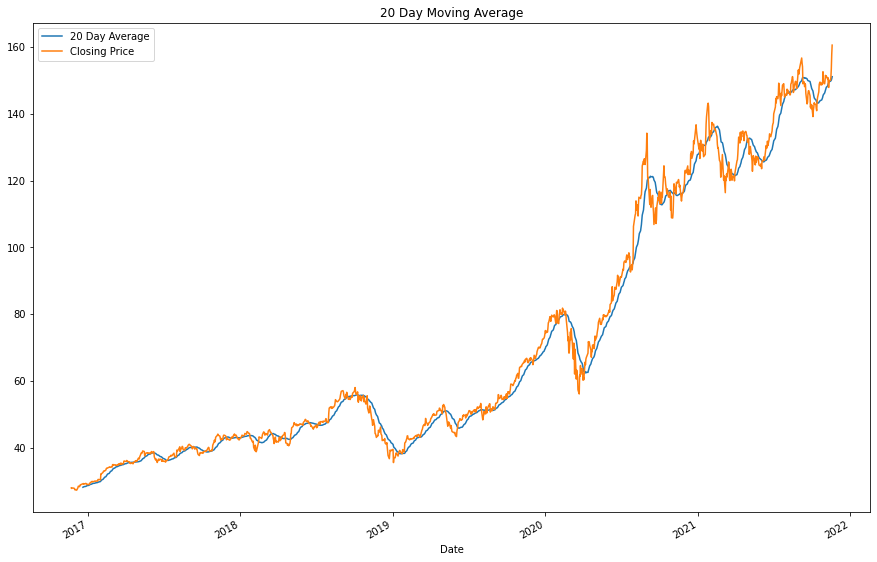

In [5]:
# Plotting moving average of last 5 years
plt.figure(figsize=(15,10))
df = extract_raw_data(5)
df[CLOSE].rolling(window=20).mean().plot(label='20 Day Average')
df[CLOSE].plot(label='Closing Price', title='20 Day Moving Average')
plt.legend()

## 3. Feature Selection ##

In [6]:
# Function to extract Stock Closing Price as a Feature from Dataframe
def select_features(df):
    return df.reset_index()[CLOSE]

## 4. Split Data into Train and Test ##

#### I. Split Data for LSTM Model ####

In [7]:
def split_data_into_train_test_lstm(model_df):
    train_index = 0.7 * model_df.shape[0]
    train_data = model_df[:int(train_index)]
    test_data = model_df[int(train_index):]
    return train_data, test_data 

In [8]:
# Function to create dataset into feature and target
def create_dataset_lstm(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

#### II. Split Data for Other Model ####


In [9]:
def split_data_into_train_test(model_df):
    train_index = 0.7 * model_df.shape[0]
    train_data = list(model_df[:int(train_index)])
    test_data = list(model_df[int(train_index):])
    return train_data, test_data

In [10]:
# For other model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i+time_step])
    return np.array(dataX), np.array(dataY)

## 5. Create, Train, Evaluate and Tune Model ##

In [11]:
# Function to tune the model 
def create_tune_model(model_name, X_train, y_train, X_test, y_test, number_of_days=20, scaler=None):
    if model_name == 'KNN':
        return create_tune_knn(X_train, y_train, X_test, y_test)
    elif model_name == 'DT':
        return create_tune_dt(X_train, y_train, X_test, y_test)
    elif model_name == 'LR':
        return create_tune_lr(X_train, y_train, X_test, y_test)
    elif model_name == 'LSTM':
        return create_tune_lstm(X_train, y_train, X_test, y_test, number_of_days, scaler)

### I. LSTM Model ###

In [12]:
# Function to tune lstm based on specific hyperparameter
def create_tune_lstm(X_train, y_train, X_test, y_test, number_of_days, scaler):
    tuned_test_set_rmse = None
    tuned_hyperparameters = None
    tuned_model = None

    for no_of_epoch in NUMBER_OF_EPOCH_LIST:
        for batch_size in BATCH_SIZE_LIST:
            model = Sequential()
            model.add(LSTM(50, return_sequences=True, input_shape=(number_of_days,1)))
            model.add(LSTM(50, return_sequences=True))
            model.add(LSTM(50))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

            model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=no_of_epoch, batch_size=batch_size)
            
            y_pred = model.predict(X_test)
            y_pred = scaler.inverse_transform(y_pred)
            y_test = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
            current_rmse = math.sqrt(mean_squared_error(y_pred, y_test))
            current_rmse = math.sqrt(mean_squared_error(model.predict(X_test), y_test))

            if tuned_test_set_rmse is None or tuned_test_set_rmse > current_rmse:
                tuned_test_set_rmse = current_rmse
                tuned_hyperparameters = {'epochs': no_of_epoch, 'batch_size': batch_size}
                tuned_model = model
                
    return tuned_model, tuned_hyperparameters, tuned_test_set_rmse

### II. Linear Regression Model ###

In [13]:
# Function to run Linear Regression - no hyperparameter available in this model
def create_tune_lr(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    current_rmse = math.sqrt(mean_squared_error(model.predict(X_test), y_test))
    
    return model, {}, current_rmse

### III. Decision Tree Regression Model ###

In [14]:
# Function to tune Decision Tree Regression based on specific hyperparameter
def create_tune_dt(X_train, y_train, X_test, y_test):
    tuned_test_set_rmse = None
    tuned_hyperparameters = None
    tuned_model = None
    
    for min_samples_split in MIN_SAMPLES_LIST:
        model = DecisionTreeRegressor(min_samples_split=min_samples_split)
        model.fit(X_train, y_train)
        current_rmse = math.sqrt(mean_squared_error(model.predict(X_test), y_test))
        
        if tuned_test_set_rmse is None or tuned_test_set_rmse > current_rmse:
            tuned_test_set_rmse = current_rmse
            tuned_hyperparameters = {'min_samples_split': min_samples_split}
            tuned_model = model
            
    return tuned_model, tuned_hyperparameters, tuned_test_set_rmse

### IV. KNN Regression Model ###

In [15]:
# Function to tune KNN Regression based on specific hyperparameter
def create_tune_knn(X_train, y_train, X_test, y_test):
    tuned_test_set_rmse = None
    tuned_hyperparameters = None
    tuned_model = None
    
    for n_neighbors in KNN_NEIGHBORS_LIST:
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)
        current_rmse = math.sqrt(mean_squared_error(model.predict(X_test), y_test))
        
        if tuned_test_set_rmse is None or tuned_test_set_rmse > current_rmse:
            tuned_test_set_rmse = current_rmse
            tuned_hyperparameters = {'n_neighbors': n_neighbors}
            tuned_model = model
            
    return tuned_model, tuned_hyperparameters, tuned_test_set_rmse

## 6. Run Model ##

In [16]:
# Function to run the model
def run_model(model_name):
    best_model = None
    best_df = None
    best_X_train = None
    best_X_test = None
    best_test_data = None
    best_test_set_rmse = None
    best_hyperparameters = None
    best_no_of_years = None
    best_no_of_days = None

    # Looping through number of years of data to find accurate data selection
    for no_of_years in NUMBER_OF_YEARS_TO_FETCH_PRICE_DATA:
        
        # Extract Raw Dataset
        df = extract_raw_data(no_of_years)
        
        # Feature Selection - selecting stock closing price
        model_df = select_features(df)
        
        # Spliting data into train and test
        if model_name == 'LSTM':
            # Tranforming value to 0-1 since lstm are sensitive to the scale of the data
            scaler = MinMaxScaler(feature_range=(0,1))
            model_df_lstm = scaler.fit_transform(np.array(model_df).reshape(-1,1))
            
            train_data, test_data = split_data_into_train_test_lstm(model_df_lstm)
        else:
            train_data, test_data = split_data_into_train_test(model_df)

        # Looping through number of days for price prediction to find best time-steps
        for no_of_days in NUMBER_OF_DAYS_FOR_PRICE_PREDICTION:
            
            # Creating dataset out of it using time-steps
            if model_name == 'LSTM':
                X_train, y_train = create_dataset_lstm(train_data, no_of_days)
                X_test, y_test = create_dataset_lstm(test_data, no_of_days)
                
                # reshape input to be [samples, time steps, features] which is required for LSTM
                X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
                
                # Traning, Evaluating and performing Hyper Parameter Tuning for the LSTM Model
                tuned_model, tuned_hyperparameters, tuned_test_set_rmse = create_tune_model(model_name, X_train, y_train, X_test, y_test, no_of_days, scaler)
            else:
                X_train, y_train = create_dataset(train_data, no_of_days)
                X_test, y_test= create_dataset(test_data, no_of_days)
                
                # Traning, Evaluating and performing Hyper Parameter Tuning for the Other Model
                tuned_model, tuned_hyperparameters, tuned_test_set_rmse = create_tune_model(model_name, X_train, y_train, X_test, y_test)
            
            # Update hyperparameters and its test accuracy
            if best_test_set_rmse is None or best_test_set_rmse > tuned_test_set_rmse:
                best_test_set_rmse = tuned_test_set_rmse
                best_hyperparameters = tuned_hyperparameters
                best_no_of_years = no_of_years
                best_no_of_days = no_of_days
                best_model = tuned_model
                best_df = model_df
                best_X_train = X_train
                best_X_test = X_test
                best_test_data = test_data
                
    return best_model, best_df, best_X_train, best_X_test, best_test_data, best_hyperparameters, best_test_set_rmse, best_no_of_years, best_no_of_days

### I. LSTM Model ###

In [ ]:
best_model_lstm,best_df_lstm, best_X_train_lstm, best_X_test_lstm, best_test_data_lstm, best_hyperparameters_lstm, \
    best_test_set_rmse_lstm, best_no_of_years_lstm, best_no_of_days_lstm = run_model('LSTM')


### II. Linear Regression Model ###

In [26]:
best_model_lr,best_df_lr, best_X_train_lr, best_X_test_lr, best_test_data_lr, best_hyperparameters_lr, \
    best_test_set_rmse_lr, best_no_of_years_lr, best_no_of_days_lr = run_model('LR')


### III. Plot train and test prediction in graph

In [27]:
best_model_dt,best_df_dt, best_X_train_dt, best_X_test_dt, best_test_dt, best_hyperparameters_dt, \
    best_test_set_rmse_dt, best_no_of_years_dt, best_no_of_days_dt = run_model('DT')


### IV. KNN Regression Model ###

In [28]:
best_model_knn,best_df_knn, best_X_train_knn, best_X_test_knn, best_test_knn, best_hyperparameters_knn, \
    best_test_set_rmse_knn, best_no_of_years_knn, best_no_of_days_knn = run_model('KNN')


## 6. Comparing and Choosing Best Model ##

### I. Displaying Model Outputs  ###

In [29]:
# Defining default values for model for comparision
default_hyperparameter_lstm = {'epochs': 1, 'batch_size': None}
default_hyperparameter_lr = {}
default_hyperparameter_dt = {'min_samples_split': 2}
default_hyperparameter_knn = {'n_neighbors': 5}

# Using pandas dataframe to show data in a nice output table
df = pd.DataFrame(
    {'Model':                               ['LSTM',                         'Linear Regression',           'Decision Tree Regression',        'KNN Regression'],
     'Default Hyperparameters':             [default_hyperparameter_lstm,    default_hyperparameter_lr,     default_hyperparameter_dt,         default_hyperparameter_knn],
     'Best Hyperparameters':                [best_hyperparameters_lstm,      best_hyperparameters_lr,       best_hyperparameters_dt,           best_hyperparameters_knn],
     'Stock Price Data (No. of Years)':     [best_no_of_years_lstm,          best_no_of_years_lr,           best_no_of_years_dt,               best_no_of_years_knn],
     'Time Series Step (No. of Days)':      [best_no_of_days_lstm,           best_no_of_days_lr,            best_no_of_days_dt,                best_no_of_days_knn],
     'RMSE':                                [best_test_set_rmse_lstm,        best_test_set_rmse_lr,         best_test_set_rmse_dt,             best_test_set_rmse_knn]
    })
df

,Model,Default Hyperparameters,Best Hyperparameters,Stock Price Data (No. of Years),Time Series Step (No. of Days),RMSE
0,LSTM,"{'epochs': 1, 'batch_size': None}","{'epochs': 25, 'batch_size': 30}",15,20,84.982604
1,Linear Regression,{},{},15,20,1.663047
2,Decision Tree Regression,{'min_samples_split': 2},{'min_samples_split': 2},5,20,50.739410
3,KNN Regression,{'n_neighbors': 5},{'n_neighbors': 5},5,20,52.029079


**Observation:**
Looking at the above RMSE score, the best model is found to be **Linear Regression**

### II. Plotting Train and Test Prediction with Best Model i.e. Linear Regression ###

In [22]:
# Common function to plot graph to evaluate Model
def plot_graph(model_df, no_of_days, model, X_train, X_test):
    # Making prediction for train and test set for plotting
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    look_back = no_of_days
    train_predict_plot = [ np.nan for i in range(len(model_df))]
    train_predict_plot[look_back:len(train_predict) + look_back] = np.array(train_predict)

    # Shift test predictions for plotting
    
    test_predict_plot = [ np.nan for i in range(len(model_df))]
    test_predict_plot[len(train_predict) + (look_back*2)+1:len(model_df)-1] = list(test_predict)

    # Plot baseline and predictions
    plt.plot(model_df)
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.show()

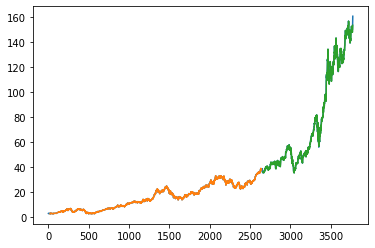

In [23]:
plot_graph(best_df_lr,best_no_of_days_lr, best_model_lr, best_X_train_lr, best_X_test_lr)

## 7. Predict Stock Market Movement Trend for Next 30 Days Using Best Model  and its Hyperparameters (Linear Regression) ##

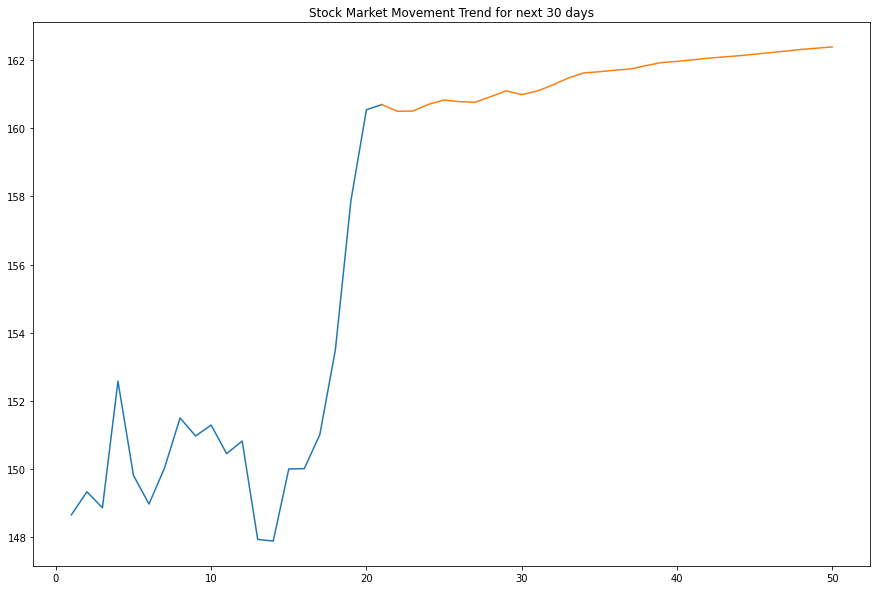

In [24]:
# Plotting Stock Market Trend for next 30 days using Linear Regression
lastest_data_index = len(best_test_data_lr) - best_no_of_days_lr
x_input = best_test_data_lr[lastest_data_index:]

temp_input = list(x_input)
temp_input = [temp_input[0]]

# demonstrate prediction for next n days
lst_output = []
last_n_days_data = best_test_data_lr[lastest_data_index : ]
next_day = None
for day in range(NUMBER_OF_DAYS_TO_PREDICT):
    if next_day is not None:
        last_n_days_data = last_n_days_data[1:]
        last_n_days_data.append(next_day)
    next_day = best_model_lr.predict([last_n_days_data])[0]
    lst_output.append(next_day)

day_new = np.arange(1,best_no_of_days_lr + 2)
day_pred = np.arange(best_no_of_days_lr + 1, best_no_of_days_lr + NUMBER_OF_DAYS_TO_PREDICT + 1)

lastest_model_df_index = len(best_df_lr) - best_no_of_days_lr

plt.figure(figsize = (15,10))

last_n_days = list(best_df_lr[lastest_model_df_index:])
last_n_days.append(lst_output[0])

plt.title('Stock Market Movement Trend for next 30 days')
plt.plot(day_new,last_n_days)
plt.plot(day_pred,lst_output)

## 8. Predict Stock Closing Price for Next Day Using Best Model (Linear Regression) ##

In [25]:
# Current Date of Model Run
print('Current Date:                 ', dt.date.today())
print('Last Stock Closing Price:     ', best_test_data_lr[-1])

# Next day price using Linear Regression
last_n_days_data = best_test_data_lr[len(best_test_data_lr) - best_no_of_days_lr:]
next_day = best_model_lr.predict([last_n_days_data])[0]

print('Next Day Stock Closing Price: ', next_day)

Current Date:                  2021-11-21
Last Stock Closing Price:      160.5500030517578
Next Day Stock Closing Price:  160.702096334333
